# BikeEase Incremental Capstone Project - Part 3

# Libraries Imports

In [1]:
from google.colab import files
import os
import zipfile
import pathlib
import shutil
from PIL import Image

import random

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [2]:
# global random seed
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Task 1: Data Preprocessing

## Extract Images

In [3]:
zip_file_name = 'images.zip'
temp_dir = pathlib.Path('/content/temp')

# extract all into temporary folder
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(temp_dir)

## Data Inspection

In [4]:
file_count = sum(1 for path in temp_dir.rglob('*') if path.is_file())
print(f'Total files: {file_count}')

Total files: 797


## Remove Non-Image Files

In [5]:
image_extensions = {'.jpg', '.jpeg', '.png', '.bmp'}

# walk through all files
for file_path in temp_dir.rglob('*'):
    # check extension
    if file_path.is_file() and file_path.suffix.lower() not in image_extensions:
        print(f"Removing non-image file: {file_path}")
        # delete the file
        file_path.unlink()

Removing non-image file: /content/temp/Bikes/Bikes(train)/pic.webp
Removing non-image file: /content/temp/Bikes/Bikes(train)/image.webp
Removing non-image file: /content/temp/Bikes/Bikes(train)/image (1).webp
Removing non-image file: /content/temp/Bikes/Bikes(train)/rtr-160-bs6_360x240.webp
Removing non-image file: /content/temp/Bikes/Bikes(train)/image (2).webp
Removing non-image file: /content/temp/Bikes/Bikes(train)/hero-glamour-bs6-right-side-view_360x240.webp


## Setup Model Data Files Structure

In [6]:
vehicles_dir = pathlib.Path('/content/vehicles')

# temp folders
bikes_src = temp_dir / 'Bikes' / 'Bikes(train)'
cars_src = temp_dir / 'Cars' / 'Cars(train)'

# target folders
bikes_target = vehicles_dir / 'bikes'
cars_target = vehicles_dir / 'cars'

# create target folders
bikes_target.mkdir(parents=True, exist_ok=True)
cars_target.mkdir(parents=True, exist_ok=True)

# move all files from Bikes(train) to vehicles/bikes
for img_path in bikes_src.glob('*'):
    if img_path.is_file():
        shutil.move(str(img_path), str(bikes_target / img_path.name))

# move all files from Cars(train) to vehicles/cars
for img_path in cars_src.glob('*'):
    if img_path.is_file():
        shutil.move(str(img_path), str(cars_target / img_path.name))

# clean up temp folder
shutil.rmtree(temp_dir)

## Recount Files

In [7]:
file_count = sum(1 for path in vehicles_dir.rglob('*') if path.is_file())
print(f'Total files: {file_count}')

bikes_dir = vehicles_dir / 'bikes'
cars_dir = vehicles_dir / 'cars'

# count image files in each
bikes_count = sum(1 for f in bikes_dir.rglob('*') if f.suffix.lower() in image_extensions and f.is_file())
cars_count = sum(1 for f in cars_dir.rglob('*') if f.suffix.lower() in image_extensions and f.is_file())

print(f"Total files in bikes: {bikes_count}")
print(f"Total files in cars: {cars_count}")

Total files: 791
Total files in bikes: 391
Total files in cars: 400


## Splitting Dataset

In [8]:
# set parameters for dataset
batch_size = 16
img_height = 180
img_width = 180

# load training data
train_ds = tf.keras.utils.image_dataset_from_directory(
    vehicles_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),    # resize images on the fly
    batch_size=batch_size
)

# load validation images
val_ds = tf.keras.utils.image_dataset_from_directory(
    vehicles_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),    # resize images on the fly
    batch_size=batch_size
)

Found 791 files belonging to 2 classes.
Using 633 files for training.
Found 791 files belonging to 2 classes.
Using 158 files for validation.


In [9]:
# check class labels
print("Class names:", train_ds.class_names)

Class names: ['bikes', 'cars']


## Rescale and Normalize Images

In [10]:
normalization_layer = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Task 2: Building the CNN Model

## Augmentation

In [11]:
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.125),            # ≈ 45 degrees = 45/360 = 0.125
    layers.RandomTranslation(0.1, 0.1),      # width_shift and height_shift
    layers.RandomZoom(0.2),                  # random zoom in/out
    layers.RandomFlip("horizontal"),         # random horizontal flip
    layers.RandomContrast(0.1),              # random contrast adjustment
])

In [12]:
# define input shape
input_shape = (img_height, img_width, 3)

model = tf.keras.Sequential([
    # input layer
    layers.Input(shape=input_shape),

    data_augmentation,                              # augmentation

    # first convolutional block (Conv2D, BatchNorm, Pooling)
    layers.Conv2D(16, 3, activation='relu'),        # detects low-level features (edges, textures)
    layers.BatchNormalization(),                    # normalizes activations to speed up training and stabilize learning
    layers.MaxPooling2D(pool_size=(2, 2)),          # downscales feature maps to reduce computation and focus on dominant features

    # second convolutional block
    layers.Conv2D(32, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # third convolutional block
    layers.Conv2D(64, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # flatten the 3D feature maps into a 1D vector for input to dense layers
    layers.Flatten(),

    # dropout for regularization
    layers.Dropout(0.2),

    # fully connected dense layer with 128 units
    layers.Dense(128, activation='relu'),           # learns global patterns from features

    layers.BatchNormalization(),

    # dropout for regularization
    layers.Dropout(0.2),                            # prevents overfitting by randomly disabling neurons during training

    # output layer for binary classification
    layers.Dense(1, activation='sigmoid')           # outputs probability: 0 (bike) or 1 (car)
])

# compile the model
model.compile(
    optimizer= Adam(learning_rate=0.0003),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# print model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 178, 178, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 87, 87, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 41, 41, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,276,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,301,601 (12.59 MB)

 Trainable params: 3,301,121 (12.59 MB)

 Non-trainable params: 480 (1.88 KB)

# Task 3: Model Training

In [13]:
epochs = 30

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 37s 789ms/step - accuracy: 0.6699 - loss: 0.7538 - val_accuracy: 0.5190 - val_loss: 1.2264
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 780ms/step - accuracy: 0.7859 - loss: 0.5840 - val_accuracy: 0.5190 - val_loss: 1.9420
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 42s 790ms/step - accuracy: 0.8126 - loss: 0.4509 - val_accuracy: 0.5190 - val_loss: 1.3878
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 769ms/step - accuracy: 0.8548 - loss: 0.3483 - val_accuracy: 0.5190 - val_loss: 1.3742
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 769ms/step - accuracy: 0.8712 - loss: 0.3204 - val_accuracy: 0.6076 - val_loss: 0.8164
Epoch 6/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 765ms/step - accuracy: 0.8618 - loss: 0.3232 - val_accuracy: 0.6519 - val_loss: 0.6642
Epoch 7/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 29s 733ms/step - accuracy: 0.8492 - loss: 0.3369 - val_accuracy: 0.7278 - val_loss: 0.4769
Epoch 8/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 30s 759ms/step - accuracy: 0.8883 - loss: 0.2706 - val_accu

## Visualize Result

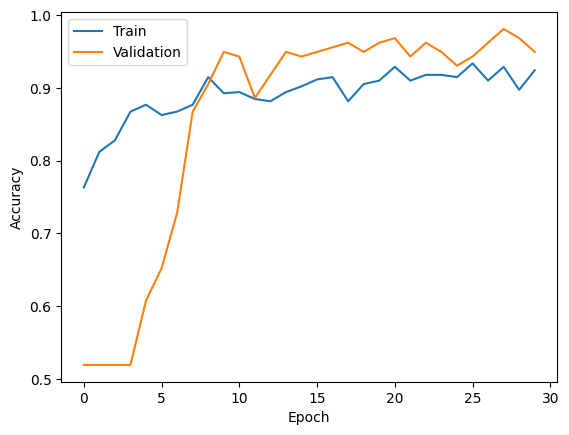

In [14]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')

# add labels
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

# Task 4: Model Evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
Classification Report:
              precision    recall  f1-score   support

        Bike       0.97      0.99      0.98        76
         Car       0.99      0.98      0.98        82

    accuracy                           0.98       158
   macro avg       0.98      0.98      0.98       158
weighted avg       0.98      0.98      0.98       158



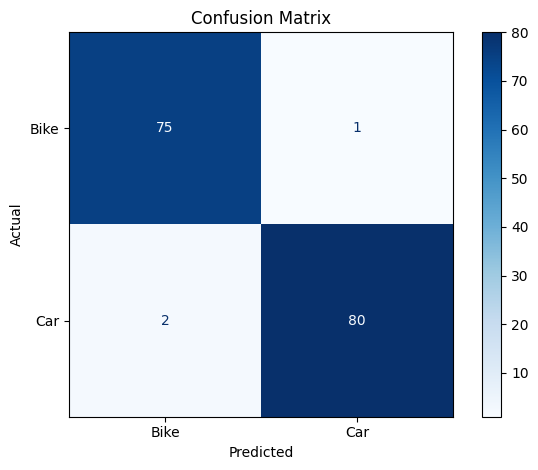

In [15]:
y_true = []
y_pred = []

# predict on test sets
for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    # convert probabilities to binary
    y_pred.extend((preds > 0.5).astype(int).flatten())


print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Bike', 'Car'], zero_division=0)) # zero_division=0 prevents warnings when precision or recall have zero true positives in one class

cm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Bike', 'Car'])

cm_display.plot(cmap='Blues')
cm_display.ax_.set_title('Confusion Matrix')
cm_display.ax_.set_xlabel('Predicted')
cm_display.ax_.set_ylabel('Actual')

plt.grid(False)

plt.tight_layout()
plt.show()

## Manual Hyperparameter Adjustments

- switched to GPU runtime to significantly accelerate model training and reduce epoch runtimes

- increased training epochs from 10 to 30 because the model was stopping too early before the validation loss had stabilized

- added early stopping with monitor='val_loss' and patience=5 to prevent overfitting and retain best weights

- reduced dropout rate from 0.5 to 0.2 to mitigate underfitting, especially given the limited dataset size

- switched from ImageDataGenerator to image_dataset_from_directory(), which is more efficient and better performance

- reduced the number of convolutional filters, as the model was reaching very high training accuracy too quickly

- used BatchNormalization() after each Conv2D layer to improve training stability and speed

- decreased width/height shift range from 0.2 to 0.1 to avoid excessive transformation that distorted training images

- increased random zoom to 0.2 to simulate partial vehicle images

- lowered batch size from 32 to 16 to reduce training noise and improve model convergence

- increased learning rate to 0.0005 which provides faster convergence and better validation accuracy compared to 0.0001

## Sample Misclassified Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


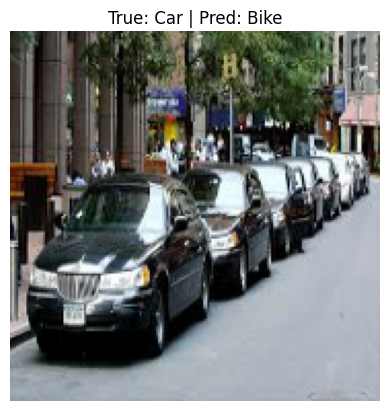

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


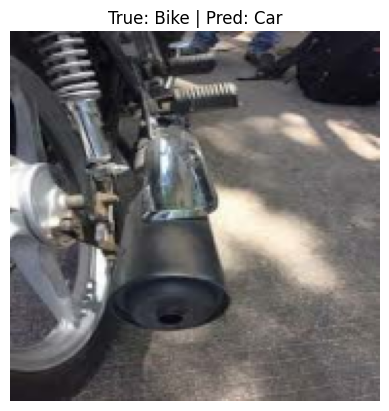

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


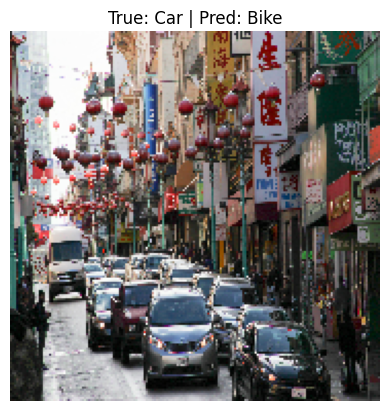

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


In [16]:
for images, labels in val_ds:
    preds = model.predict(images)
    pred_labels = (preds > 0.5).astype(int).flatten()
    for i in range(len(images)):
        if pred_labels[i] != labels[i]:
            plt.imshow(images[i].numpy())
            plt.title(f"True: {'Car' if labels[i] else 'Bike'} | Pred: {'Car' if pred_labels[i] else 'Bike'}")
            plt.axis('off')
            plt.show()

# Task 5: Visualization and Reporting

## Visualization of Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


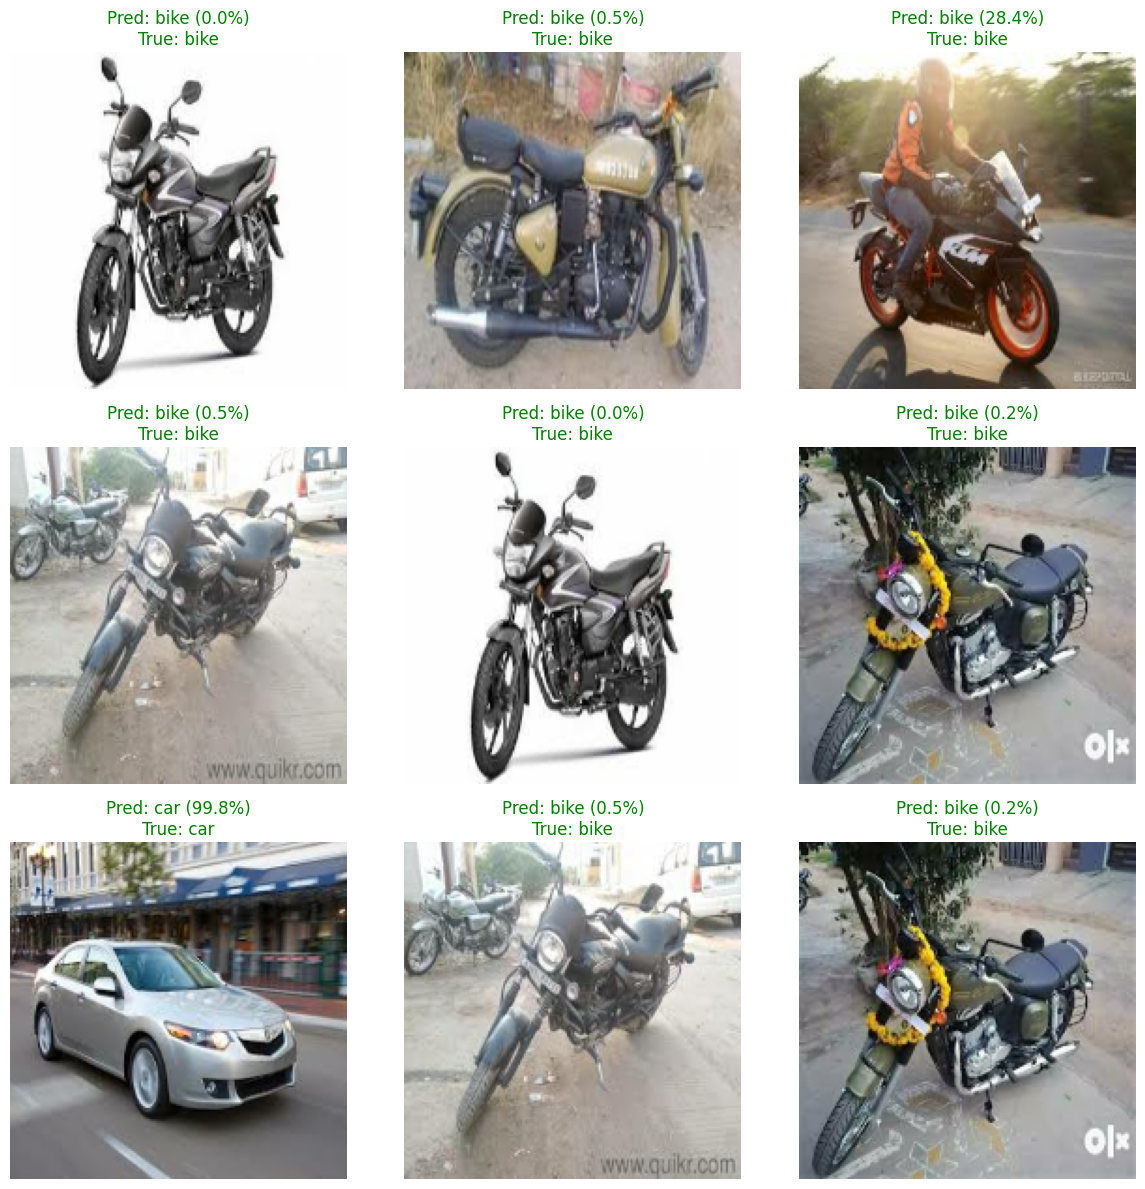

In [17]:
class_names = ['bike', 'car']

for images, labels in val_ds.take(1):
    predictions = model.predict(images)
    predicted_classes = (predictions > 0.5).astype(int).flatten()

    # plot 9 random images from the batch
    plt.figure(figsize=(12, 12))
    for i in range(9):
        index = random.randint(0, len(images) - 1)
        img = images[index].numpy()
        true_label = class_names[labels[index].numpy()]
        pred_label = class_names[predicted_classes[index]]
        confidence = predictions[index][0] * 100

        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.axis('off')

        # green if correct, red if incorrect
        color = 'green' if pred_label == true_label else 'red'
        title = f"Pred: {pred_label} ({confidence:.1f}%)\nTrue: {true_label}"
        plt.title(title, color=color)

    plt.tight_layout()
    plt.show()

## Report

This project aimed to classify images as either bikes or cars using a custom Convolutional Neural Network (CNN). The model was trained on a small dataset and manually tuned to improve generalization and performance.

The CNN architecture combined Convolution, Pooling, and Dense layers, with Batch Normalization and Dropout to improve gradient stability and reduce overfitting. Data augmentation was applied to simulate real-world variation, such as zoom and image shift.

During the tuning process, it became clear that the dataset was highly sensitive to augmentation. Excessive transformations led to unstable validation loss and inconsistent accuracy, likely due to the limited dataset size.

Key optimizations included increasing training epochs from 10 to 30, reducing dropout to 0.2 to avoid underfitting, lowering the batch size to 16, and setting the learning rate to 0.0005 for faster convergence. Early stopping helped prevent overfitting by halting training when validation loss stopped improving.

Model performance improved steadily over time. After an initial period of overfitting, validation accuracy began rising consistently while validation loss decreased. These trends suggest strong classification performance and solid generalization to unseen data.

Despite the improvements, some misclassifications remained, likely due to the small dataset and limited image diversity. Notable misclassifications included non-typical images such as partial vehicles or images containing multiple vehicles.

Future improvements could include using a pre-trained model for transfer learning, applying class activation maps to visualize what the model is learning, expanding the dataset to enhance robustness and reduce sensitivity to augmentation, and extending the model to support multi-class classification for differentiating between multiple types of vehicles or environmental conditions.

# Now You Try!
Upload an image of a bike or car and see if the model can classify it!

Saving cartoon.jpg to cartoon.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


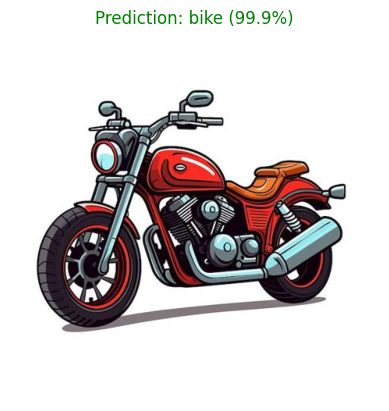

In [18]:
# @title
# track the last uploaded file
last_uploaded_file = None

# delete the previous uploaded image if it exists
if 'last_uploaded_file' in globals() and last_uploaded_file and os.path.exists(last_uploaded_file):
    os.remove(last_uploaded_file)

# upload image
uploaded = files.upload()

# load and preprocess image
latest_filename = list(uploaded.keys())[-1]
last_uploaded_file = latest_filename                  # update the tracker

img = Image.open(latest_filename).convert('RGB')

# process the image
img_resized = img.resize((img_width, img_height))     # resize
img_array = np.array(img_resized) / 255.0             # normalize
processed_image = np.expand_dims(img_array, axis=0)   # add batch dimension

# predict
prediction = model.predict(processed_image)[0][0]
predicted_class = 1 if prediction >= 0.5 else 0
confidence = prediction * 100 if predicted_class == 1 else (1 - prediction) * 100

plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {class_names[predicted_class]} ({confidence:.1f}%)", color='green')
plt.show()